In [9]:
from src.networks import UNetModel
import torch

model = UNetModel(
    image_size=32,
    in_channels=1,
    out_channels=1,
    model_channels=64,
    num_res_blocks=2,
    attention_resolutions=[16, 8],
    dropout=0.1,
    channel_mult=[1,2,4,4],
    num_classes=2,
    num_heads=4
)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

x = torch.randn(1, 32, 224)
t = torch.rand((1,))
c = torch.randint(0, 2, (1,))
out = model(x, t, c)
print(out.shape)

25303169
torch.Size([1, 32, 224])


In [5]:
from src.networks.speech_separation import SpeechbrainSepformer
from src.dataset import LibriWHAM

dataset = LibriWHAM(length_seconds=4.096, sample_rate=8000)
sepformer = SpeechbrainSepformer(source="sepformer-wham")

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham' if not cached
INFO:speechbrain.utils.fetching:Fetch masknet.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham' if not cached
INFO:speechbrain.utils.fetching:Fetch encoder.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham' if not cached
INFO:speechbrain.utils.fetching:Fetch decoder.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: masknet, encoder, decoder
/work3/s214630/Latent-DSB/.venv/lib/python3.11/site-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct mal

Loaded SpeechbrainSepformer from sepformer-wham with 25679361 parameters.


In [8]:
sample = dataset[0].unsqueeze(0)
out = sepformer.separate(sample, sample_rate=8000)

from IPython.display import display, Audio

display(Audio(out.flatten(), rate=8000))
display(Audio(sample.flatten(), rate=8000))

In [1]:
from src.networks.speech_separation import SpeechbrainSepformer

sepformer = SpeechbrainSepformer(source="sepformer-wham")

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham' if not cached
INFO:speechbrain.utils.fetching:Fetch masknet.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham' if not cached
INFO:speechbrain.utils.fetching:Fetch encoder.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham' if not cached
INFO:speechbrain.utils.fetching:Fetch decoder.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: masknet, encoder, decoder
/work3/s214630/Latent-DSB/.venv/lib/pyt

Loaded SpeechbrainSepformer from sepformer-wham with 25679361 parameters.


Using cache found in /work3/s214630/.cache/torch/hub/snakers4_silero-vad_master


In [ ]:

from src.dataset import AllLibri, LibriWHAM
from IPython.display import display, Audio
from src.callbacks.utils import get_batch_from_dataset

dataset = LibriWHAM(length_seconds=4.096, sample_rate=16000, train=False, return_pair=True)
x0, x1 = get_batch_from_dataset(dataset, batch_size=8)
out = sepformer.separate(x1, sample_rate=16000)
for i in range(8):
    display(Audio(out[i].flatten(), rate=16000))


IndexError: index 8 is out of bounds for dimension 0 with size 8

In [57]:
from torch import Tensor
import torch
from torch.nn import Module

class STFTEncoderDecoder(Module):
    def __init__(
        self,
        n_fft : int,
        hop_length : int,
    ):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = n_fft
        self.rho = 0.1
        
    def encode(self, audio : Tensor) -> Tensor:
        if not hasattr(self, 'original_length'):
            self.original_length = audio.shape[-1]
        
        audio = torch.cat((audio, torch.zeros(audio.shape[0], audio.shape[1], self.n_fft - 1, device=audio.device)), dim=-1)
        audio = audio.squeeze(1)
        window = torch.hamming_window(self.win_length, device=audio.device)
        stft = torch.stft(
            audio, 
            n_fft=self.n_fft, 
            hop_length=self.hop_length, 
            win_length=self.win_length, 
            center=False,
            window=window,
            return_complex=True
            )

        amplitude = stft.abs().log()
        angle = stft.angle()

        out = torch.stack([amplitude, angle], dim=1)
        return out
    
    def decode(self, encoded : Tensor) -> Tensor:
        cos_amplitude, sin_amplitude = encoded[:,0], encoded[:,1]
        amplitude = (cos_amplitude**2 + sin_amplitude**2) ** (1/(2*self.rho))
        angle = torch.atan2(sin_amplitude, cos_amplitude)
        stft = amplitude * torch.exp(1j * angle)

        window = torch.hamming_window(self.win_length, device=stft.device)
        audio = torch.istft(
            stft, 
            n_fft=self.n_fft, 
            hop_length=self.hop_length, 
            win_length=self.win_length, 
            center=False,
            window=window
        )
        audio = torch.nn.functional.pad(audio, (0, self.original_length - audio.shape[-1]), mode='constant', value=0)
        return audio.unsqueeze(1)

In [58]:
from src.dataset import LibriWHAM
from src.callbacks.utils import get_batch_from_dataset
import torch

# encoder = STFTEncoderDecoder2(n_fft=510, hop_length=256)
encoder = STFTEncoderDecoder(n_fft=510, hop_length=128)

dataset = LibriWHAM(length_seconds=4.096)
audio = get_batch_from_dataset(dataset, batch_size=5)

encoded = encoder.encode(audio)
decoded = encoder.decode(encoded)

print(encoded.shape)
print(decoded.shape)

torch.Size([5, 2, 256, 512])
torch.Size([5, 1, 65536])


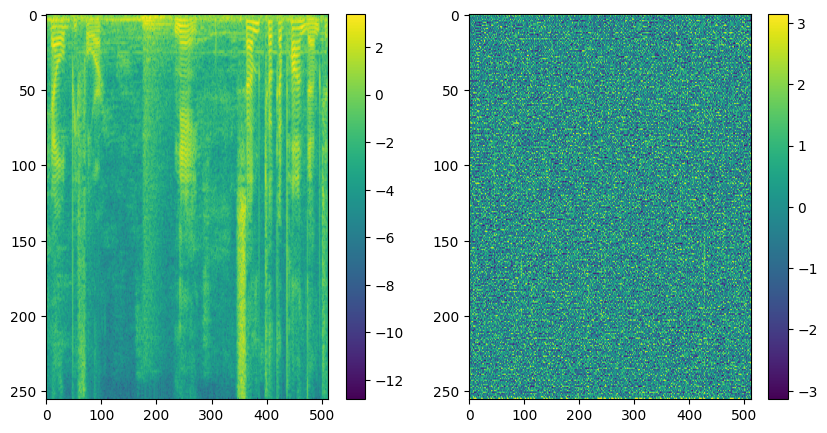

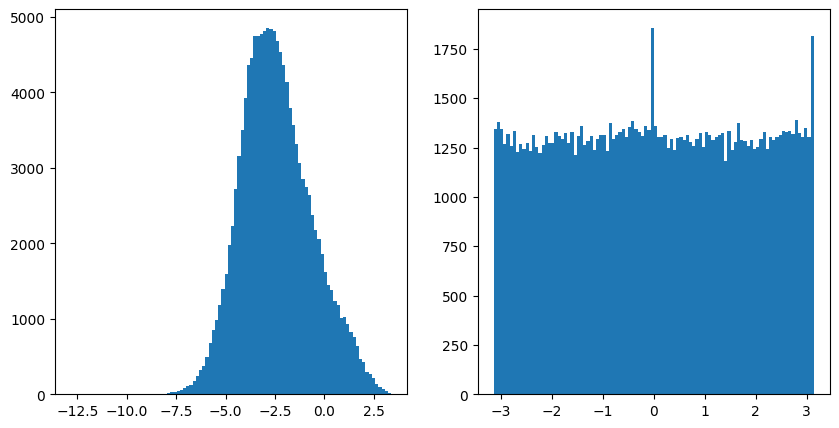

In [59]:
import matplotlib.pyplot as plt

sample = encoded[0]
n_channels = sample.shape[0]

fig, axs = plt.subplots(1, n_channels, figsize=(10, 5))
axs : list[plt.Axes]
for i in range(n_channels):
    axs[i].imshow(sample[i].squeeze(), aspect='auto')
# add colorbar
for ax in axs:
    plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
plt.show()
    
fig, axs = plt.subplots(1, n_channels, figsize=(10, 5))
axs : list[plt.Axes]
for i in range(n_channels):
    axs[i].hist(sample[i].flatten(), bins=100)
plt.show()

In [19]:
from IPython.display import display, Audio

display(Audio(decoded[1].flatten(), rate=16000))
display(Audio(audio[1].flatten(), rate=16000))